In [ ]:
!nvcc --version

In [ ]:
!nvidia-smi

In [82]:
import torch
torch.cuda.is_available()

True

In [5]:
#if the above came up false, follow this
#https://www.cyberciti.biz/faq/ubuntu-linux-install-nvidia-driver-latest-proprietary-driver/
# from this github issue https://github.com/pytorch/pytorch/issues/15612

In [6]:
torch.version.cuda

'9.2'

In [7]:
torch.backends.cudnn.enabled

True

In [2]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [4]:
#Fully connected Q-Network

# Objective: Maximize the expected value of the Q-function using the state
# and the policy selected action for the state
class FCQV(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32, 32),
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc
        
        
        #input layer 
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        #hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) -1):
            in_dim = hidden_dims[i]
            if i == 0:
                in_dim += output_dim
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        #output is a single node representing the value of the state-action pair
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
        #use a gpu if you have it 
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        #tell the device to work on 
        self.device = torch.device(device)
        self.to(self.device)

        
    #change the data to torch.Tensors if 
    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(x))
        for i , hidden_layer in enumerate(self.hidden_layers):
            #concatenate the actions to the state on the first hidden layer
            if i == 0:
                #add each row value in u to the corresponding row in x
                x = torch.cat((x, u), dim = 1)
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)


    # return each state, action, new_states, rewards, and is terminal
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals
        
                
    

In [5]:
#Fully connected deterministic policy
class FCDP(nn.Module):
    def __init__(self,
                 input_dim,
                 action_bounds,
                 hidden_dims=(32,32),
                 activation_fc=F.relu,
                 out_activation_fc=F.tanh):   #bound the activation between -1 and 1
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc
        self.out_activation_fc = out_activation_fc
        
        # set the min and max so that we can rescale the bounds for the return 
        self.env_min, self.env_max = action_bounds
        
        #states in, actions out
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))
        
        #use a gpu if you have it 
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        # environmental min and max into tensors
        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        #min and max for a continous distribution
        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')])).to(self.device)
        
        
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min
    
        #format the state into a tensor if it is not
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    
    def forward(self, state):
        x = self._format(state) #make sure state is a tensor
        x = self.activation_fc(self.input_layer(x)) #input
        for hidden_layer in self.hidden_layers:   #hidden layers
            x = self.activation_fc(hidden_layer(x)) 
        x = self.output_layer(x) #output
        x = self.out_activation_fc(x) #output activation
        return self.rescale_fn(x) #return the rescale of -1 to 1

In [6]:
class ReplayBuffer():
    def __init__(self,
                 max_size=10000,
                 batch_size=64
                ):
        #initialize the size of the array
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        
        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
        
    #store the state, action, reward, 
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size
        
        #once size variable adds past the max size it will keep growing
        #so the max_size is used after that
        self.size += 1
        self.size = min(self.size, self.max_size)
    
    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences
    
    def __len__(self):
        return self.size
        

In [7]:
class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds
        self.ratio_noise_injected = 0
        
    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()
            
        action = np.clip(greedy_action, self.low, self.high)
        return np.reshape(action, self.high.shape)

In [8]:
class NormalNoisyDecayStategy():
    def __init__(self, bounds, exploration_noise_ratio=0.1):
        self.low, self.high = bounds
        self.exploration_noise_ratio = exploration_noise_ratio
        self.ratio_noise_injected = 0
    
    def select_action(self, model, state, max_exploration=False):
        #to maximize exploration, we set the noise scale to the maximum action
        # otherwise scale it down
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.exploration_noise_ratio * self.high
        
        #get the greedy action from the network
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data
            greedy_action = greedy_action.numpy().squeeze()
       
        
        #loc = mean, scale = std.deviation, size =  length
        #gaussian noise with mean 0 and the scale
        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        
        
        #add noise
        noisy_action = greedy_action + noise
        
        #this makes the values that are not in range set to the min or max of the range
        action = np.clip(noisy_action, self.low, self.high)
        
        #  normalize noise
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action
        

In [9]:
class DDPG():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn #ReplayBuffer

        self.policy_model_fn = policy_model_fn #FCDP
        self.policy_max_grad_norm = policy_max_grad_norm #float('inf')
        self.policy_optimizer_fn = policy_optimizer_fn #optim.Adam
        self.policy_optimizer_lr = policy_optimizer_lr #.0003
        
        self.value_model_fn = value_model_fn #FCQV
        self.value_max_grad_norm = value_max_grad_norm #float('inf')
        self.value_optimizer_fn = value_optimizer_fn #optim.Adam
        self.value_optimizer_lr = value_optimizer_lr #.0003

        self.training_strategy_fn = training_strategy_fn #NormalNoisyDecayStategy
        self.evaluation_strategy_fn = evaluation_strategy_fn #GreedyStrategy

        self.n_warmup_batches = n_warmup_batches #5
        self.update_target_every_steps = update_target_every_steps #1
        self.tau = tau #0.005

    # takes a mini-batch of experiences 
    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        
        #Setup loss value function parameters
        
        # policy_model_fn set in train, FCDP forward (state)
        # this is mu
        # query for the best actions
        argmax_a_q_sp = self.target_policy_model(next_states)
        
        # target_value_model set in train, FCQV forward (state, action)
        # Query for the Q-value
        
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        
        
        #loss function (L_i _(theta_i)) #the folling lines until the loss calculation
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_value_model(states, actions)
        
        # calculate the error
        td_error = q_sa - target_q_sa.detach()
        
        #calculate the loss
        value_loss = td_error.pow(2).mul(0.5).mean()
        
        #optimizer step
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(), self.value_max_grad_norm)
        self.value_optimizer.step()

        
        
        # Set up the deterministic policy  
        
        # policy_model_fn set in train, FCDP forward (state)
        # select the best action given a state
        argmax_a_q_s = self.online_policy_model(states)
        
        # target_value_model set in train, FCQV forward (state, action)
        # Query for the Q-value
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        
        #not sure why the policy loss is negative
        policy_loss = -max_a_q_s.mean()
        
        #optimizer step
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
        return new_state, is_terminal
    
    def update_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_networks(tau=1.0)
        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)        
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_networks()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode-1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [10]:
ddpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'Pendulum-v0',
        'gamma': 0.99,
        'max_minutes': 20,
        'max_episodes': 500,
        'goal_mean_100_reward': -150
    }

    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(256,256))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0003

    training_strategy_fn = lambda bounds: NormalNoisyDecayStategy(bounds, exploration_noise_ratio=0.1)
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=256)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.005
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = DDPG(replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddpg_results = np.array(ddpg_results)
_ = BEEP()

el 00:00:01, ep 0000, ts 0000200, ar 10 -1296.7±000.0, 100 -1296.7±000.0, ex 100 0.3±0.0, ev -1391.7±000.0
el 00:02:14, ep 0117, ts 0023600, ar 10 -146.2±070.6, 100 -170.3±162.4, ex 100 0.0±0.0, ev -147.6±095.7
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score -127.44±78.78 in 125.96s training time, 140.15s wall-clock time.

el 00:00:00, ep 0000, ts 0000200, ar 10 -1373.7±000.0, 100 -1373.7±000.0, ex 100 0.3±0.0, ev -1743.3±000.0
el 00:02:16, ep 0120, ts 0024200, ar 10 -181.0±109.0, 100 -142.2±088.0, ex 100 0.0±0.0, ev -149.6±084.8
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score -143.03±78.51 in 128.75s training time, 141.57s wall-clock time.

el 00:00:00, ep 0000, ts 0000200, ar 10 -1364.0±000.0, 100 -1364.0±000.0, ex 100 0.3±0.0, ev -1923.0±000.0
el 00:05:01, ep 0251, ts 0050400, ar 10 -97.4±116.5, 100 -151.9±092.4, ex 100 0.0±0.0, ev -156.6±089.2
el 00:05:46, ep 0286, ts 0057400, ar 10 -181.7±060.4, 100 -156.5±092.6, ex 100 0.0±0.0, ev

In [ ]:
!sudo apt-get install ffmpeg

In [87]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm


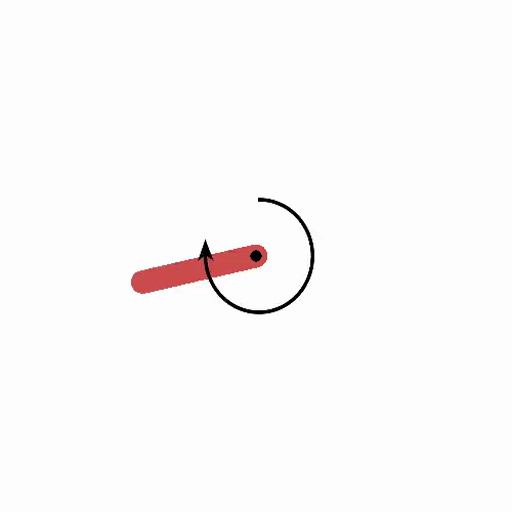
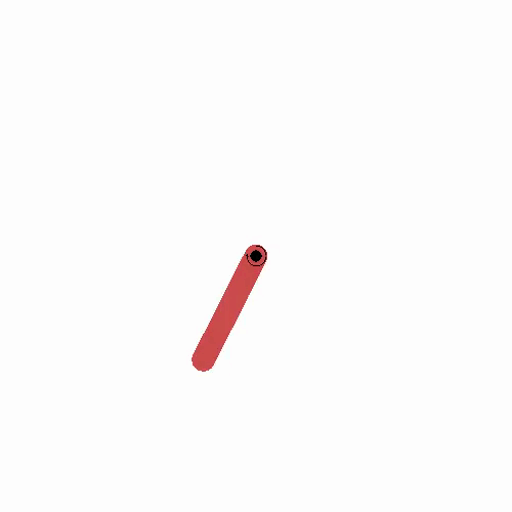
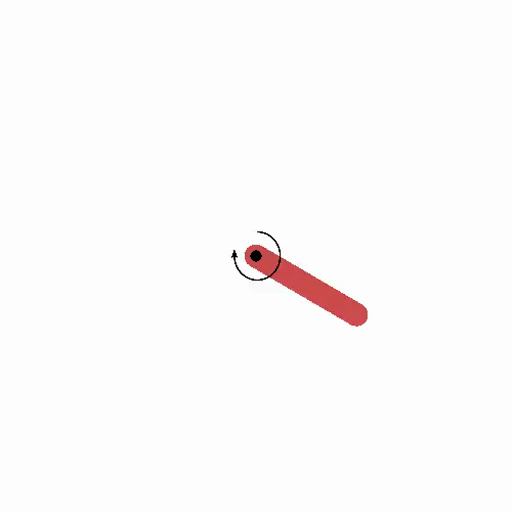
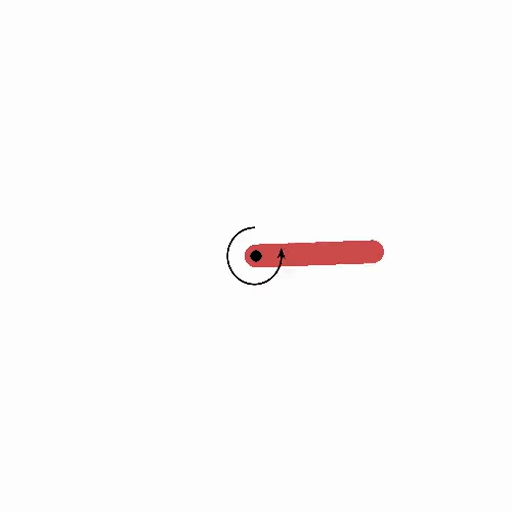

In [88]:
best_agent.demo_progression()

In [4]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
np.clip(a, 1, 8)

array([1, 1, 2, 3, 4, 5, 6, 7, 8, 8])

In [12]:
noise = np.random.normal(loc=0, scale=.1, size=(1, 10))
noise

array([[ 0.1379392 ,  0.12621558,  0.01239835,  0.14031949,  0.15037873,
         0.14003901,  0.05277894, -0.08973711,  0.13272358,  0.03918066]])

In [26]:
x = torch.randn(4, 6)
x

tensor([[-0.7776, -1.6559,  1.0647,  0.4161,  1.3967,  1.9610],
        [-0.5973, -0.1176, -0.0510, -1.0470, -0.7622, -0.2222],
        [ 0.8981, -0.0025, -1.0022, -0.1056, -0.0086,  0.9865],
        [-0.2384, -0.6869,  0.0637,  0.3867,  0.7549, -1.0014]])

In [29]:
y = torch.randn(4, 6)
y

tensor([[ 1.6235, -0.8895, -0.1597, -0.5396,  0.1663, -1.3120],
        [-0.6362,  0.9212,  0.0260, -0.4678, -0.5453,  0.4746],
        [ 1.1242,  0.6878, -1.0395,  1.2315,  0.4138, -2.2657],
        [-0.0937, -1.9000, -0.9943,  1.0722,  0.3126,  0.8512]])

In [30]:
torch.cat((x, y, x), 1)

tensor([[-0.7776, -1.6559,  1.0647,  0.4161,  1.3967,  1.9610,  1.6235, -0.8895,
         -0.1597, -0.5396,  0.1663, -1.3120, -0.7776, -1.6559,  1.0647,  0.4161,
          1.3967,  1.9610],
        [-0.5973, -0.1176, -0.0510, -1.0470, -0.7622, -0.2222, -0.6362,  0.9212,
          0.0260, -0.4678, -0.5453,  0.4746, -0.5973, -0.1176, -0.0510, -1.0470,
         -0.7622, -0.2222],
        [ 0.8981, -0.0025, -1.0022, -0.1056, -0.0086,  0.9865,  1.1242,  0.6878,
         -1.0395,  1.2315,  0.4138, -2.2657,  0.8981, -0.0025, -1.0022, -0.1056,
         -0.0086,  0.9865],
        [-0.2384, -0.6869,  0.0637,  0.3867,  0.7549, -1.0014, -0.0937, -1.9000,
         -0.9943,  1.0722,  0.3126,  0.8512, -0.2384, -0.6869,  0.0637,  0.3867,
          0.7549, -1.0014]])